# DL - Fase 2 

### 1. Importar librerías
Lo primero que vamos a hacer es cargar los módulos necesarios de varias librerías y comprobar que existe un GPU disponible para entrenar las redes

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from keras import applications
from keras import optimizers
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense

import tensorflow as tf

# Comprobamos que alguna GPU está disponible
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


### 2. Preparar datos de entrenamiento
En primer lugar obtenemos desde Drive el fichero **DL_UNIMIB2016.zip** facilitado y que contiene:

*   Una carpeta **images** con 1027 imágenes de bandejas de comida
*   Un fichero **percentage.csv** con los nombres de todas las imágenes (columna *image_name*) y el porcentaje de píxeles que contienen comida en la imagen.

A continuación, utilizaremos el método *train_test_split* de Scikit-learn para dividir los datos en tres particiones: **entrenamiento, validación y test**. En este ejemplo, hemos utilizado el 70% de las imágenes para entrenamiento, el 15% para validación y el 15% para test.

Por último, utilizaremos los método *ImageDataGenerator()* y *flow_from_dataframes()* para generar batches de imágenes.


In [0]:
# Montamos el Google Drive en el directorio del proyecto y descomprimios el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/DL_UNIMIB2016.zip' >> /dev/null

# Especificamos los paths al directorio que contiene las imagenes y al fichero con las etiquetas
data_path = 'UNIMIB2016/'
imgs_path = data_path + "images/"
labels_path = data_path + "percentage.csv"

# Leemos el fichero CSV con las etiquetas
labels = pd.read_csv(labels_path, dtype = {"food_pixels": np.float64})

# Creamos las tres particiones de datos: entrenamiento, validación y test
seed = 0
train_data, test_data = train_test_split(labels, test_size=0.3, random_state=seed)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed)

# Actualizamos los indices de cada particion
train_data = train_data.reset_index(drop=True)
dev_data = dev_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Preparamos los datos utilizando normalización (rescale)
datagen = ImageDataGenerator(rescale=1./255)

# Especificamos una serie de parámetros dependientes del conjunto de datos
# IMPORTANTE! El valor de img_width y img_height se tiene que cambiar a 331 cuando se vaya a entrenar NASNetLarge
img_width = img_height = 299  # dimensiones de la imagen
x_col = 'image_name'          # nombres de las columnas en el fichero CSV
y_col = 'food_pixels'
batch_size = 128              # tamaño del batch

# Generamos los batches con los datos para las tres particiones
train_generator = datagen.flow_from_dataframe(dataframe=train_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                            class_mode="other", target_size=(img_width,img_height), batch_size=batch_size)
dev_generator = datagen.flow_from_dataframe(dataframe=dev_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                          class_mode="other", target_size=(img_width,img_height), batch_size=batch_size)
test_generator = datagen.flow_from_dataframe(dataframe=test_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                           class_mode="other", target_size=(img_width,img_height), batch_size=batch_size)

## 3. Transfer learning
Una alternativa a crear una CNN y entrenarla desde cero, es utilizar modelos pre-entrenados con grandes conjuntos de datos. En este caso, vamos a utilizar los modelos Xception, InceptionResNetV2 y NASNetLarge pre-entrenado con ImageNet.

Al modelo base le añadiremos unas capas finales que nos permitan resolver nuestro problema de regresión. Los parámetros de estas nuevas capas se inicializarán aleatoriamente y se aprenderán durante el proceso de entrenamiento, mientras que el resto de pesos del modelo permacerán fijos. Para ello, se utiliza el campo *trainable* de las capas en Keras (es decir, los pesos del resto de capas serán los correspondientes al modelo base entrenado con ImageNet).

### Funciones y paramétros
A continuación se definen los parametros y las funciones necesarias para ejecutar las distintas redes

In [0]:
# ------------------------------------------------------------------------------
# Función de perdida RMSE
# ------------------------------------------------------------------------------
def rmse(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

# ------------------------------------------------------------------------------
# Función para dibujar la gráfica con los valores loss
# ------------------------------------------------------------------------------
def plot_loss(history):
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'])
  plt.ylim([0, 4])

# ------------------------------------------------------------------------------
# Función para dibujar la gráfica con los valores rmse
# ------------------------------------------------------------------------------
def plot_rmse(history):
  plt.figure()
  plt.plot(history.history['rmse'])
  plt.plot(history.history['val_rmse'])
  plt.title('model rmse')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'])
  plt.ylim([0, 4])

# ------------------------------------------------------------------------------
# Función para crear y compilar un modelo
# ------------------------------------------------------------------------------
def generate_model(bm, lr, nHidden1 = 1024, nHidden2 = 512):
  # Cargar el modelo base preentrenado sin la última capa
  base_model = None
  if bm == 'Xception':
    base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))
  elif bm == 'InceptionResNetV2':
    base_model = applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))
  else:
    base_model = applications.NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))
    
  # Evitar el entrenamiento de las capas preentrenadas
  for layer in base_model.layers:
    layer.trainable = False   # por defecto, el valor de trainable es True
  
  # Añadir nuevas capas
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(nHidden1, activation='relu')(x)
  x = Dense(nHidden2, activation='relu')(x)
  # Añadimos una última capa completamente conectada con 1 neurona (sin función de activación) para obtener la salida de la red
  predictions = Dense(1)(x)
  
  # Creamos el modelo final y lo compilamos
  model = Model(inputs=[base_model.input], outputs=[predictions])
  model.compile(
      loss='mse',                       # función de pérdida para problemas de regresión
      optimizer=optimizers.adam(lr=lr), # optimizador Adam, learning rate (lr)
      metrics=[rmse]
  )
  return model

# ------------------------------------------------------------------------------
# Función para ejecutar las pruebas sobre una red
# ------------------------------------------------------------------------------
def execute10Search(bm):
  # Bucle de prueba de hiperparametros
  rmse_scores = []
  for i in range(0,4):
    # Obtener hiperparametros de forma aleatoria dentro de los rangos
    # Primera ejecución con valores medios predefinidos
    hp_learningRate = 1e-04 if i == 0 else random.choice([1e-3, 1e-4, 1e-5])
    hp_epochs = 100 if i == 0 else random.choice([50, 100, 150])
    hp_hidden1 = 1024 if i == 0 else random.randint(513, 1024)
    hp_hidden2 = 512 if i == 0 else random.randint(2, 512)
    
    # Generar el modelo
    model = generate_model(bm, hp_learningRate, hp_hidden1, hp_hidden2)
    
    # Mostrar la arquitectura de la red en la primera iteración
    if i == 0:
      model.summary()
    
    print()
    print()
    print("ITERATION %d :" % (i+1))
    print(' - Name: %s' % bm)
    print(' - Learning Rate: {}'.format(hp_learningRate))
    print(' - Epochs: %d' % hp_epochs)
    print(' - Neurons 1: %d' % hp_hidden1)
    print(' - Neurons 2: %d' % hp_hidden2)
    print()
    
    # Entrenamos el modelo
    print('Entrenando red...')
    history = model.fit_generator(
        train_generator,
        epochs=hp_epochs,
        verbose=0,
        steps_per_epoch=len(train_data)/batch_size,
        validation_data=dev_generator,
        validation_steps=len(dev_data)/batch_size
    )
    
    # Evaluamos el modelo
    print()
    test_loss, test_rmse = model.evaluate_generator(
        test_generator,
        steps=len(test_data)/batch_size,
        verbose=1
    )
    
    # Mostramos los resultados de la iteración
    print("test_loss: %.4f, test_rmse: %.4f" % (test_loss, test_rmse))
    plot_loss(history)
    plot_rmse(history)
    rmse_scores.append(test_rmse)
    
  # Mostramos la mejor iteración
  print()
  print()
  min_rmse = min(rmse_scores)
  print('Best Iteration: %d' % rmse_scores.index(min_rmse))
  print('Best rmse: %d' % min_rmse)

### Xception



==                               MODEL  SUMMARY                               ==
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

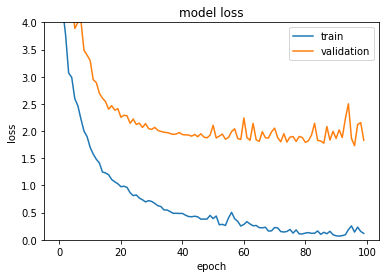

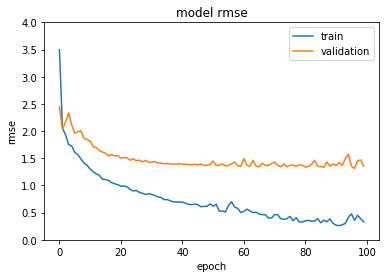

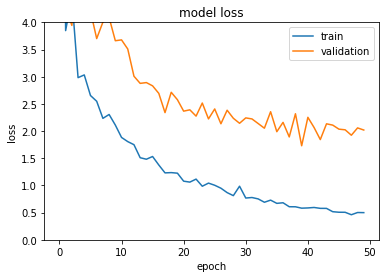

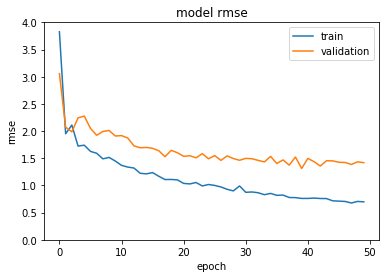

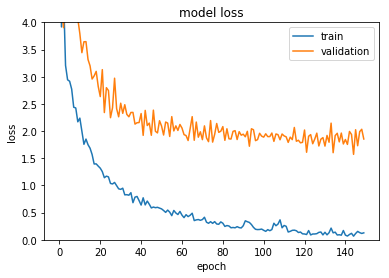

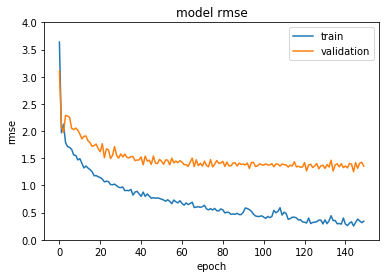

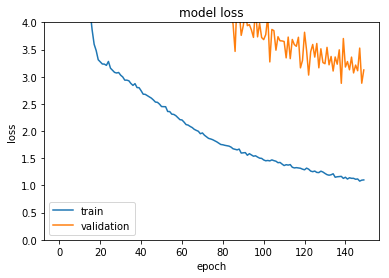

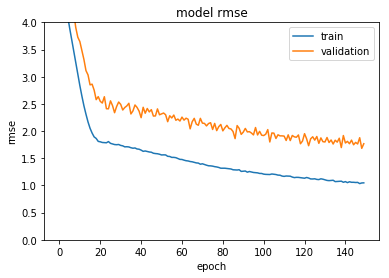

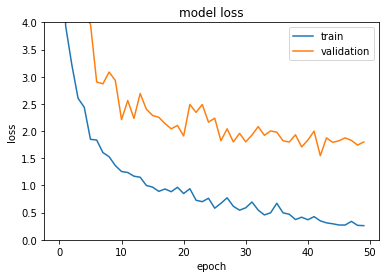

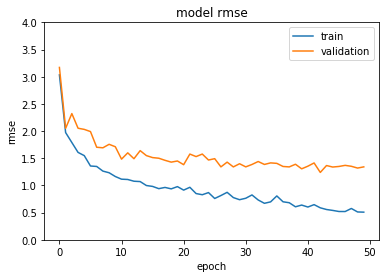

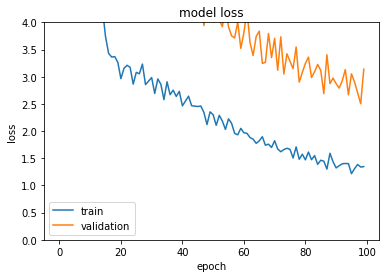

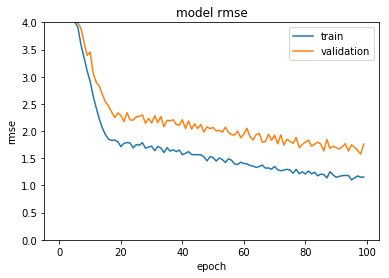

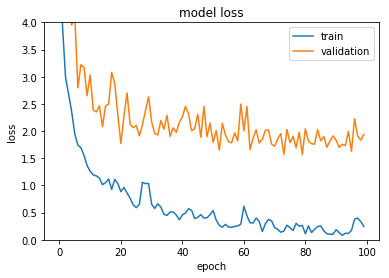

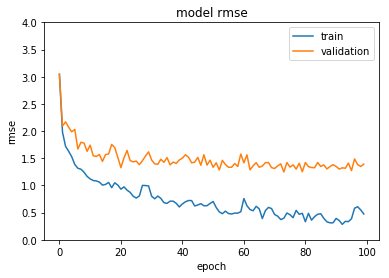

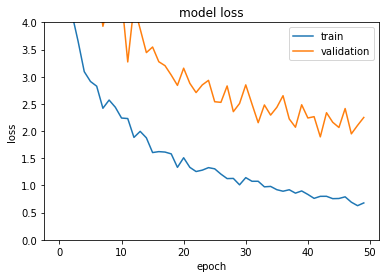

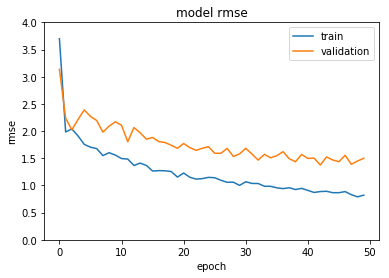

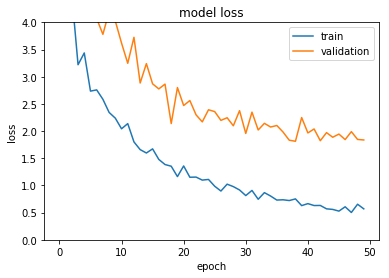

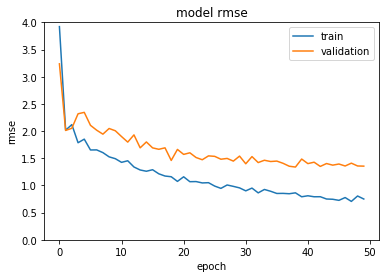

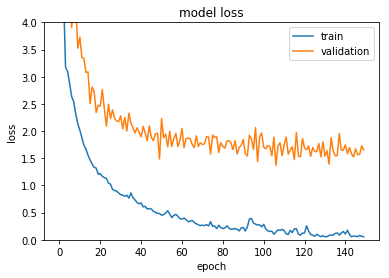

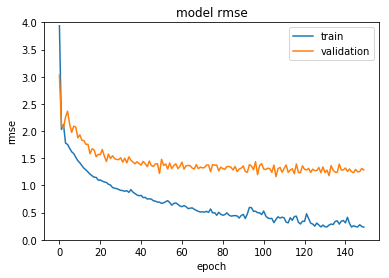

In [0]:
# Ejecutamos la función de entrenamiento con la red Xception
execute10Search('Xception')

### InceptionResNetV2

219062272/219055592 [==============================] - 5s 0us/step


==                               MODEL  SUMMARY                               ==
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 149, 149, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_152 (BatchN (None, 149, 149, 32) 96          conv2d_152[0][0]                 
__________________________________________________________________________________________________
activation_107 (Activation)     (None, 149, 149, 32) 0    

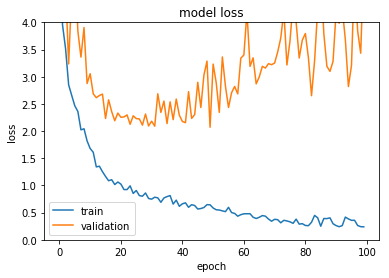

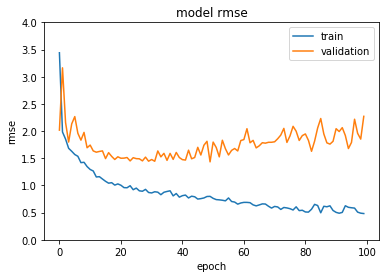

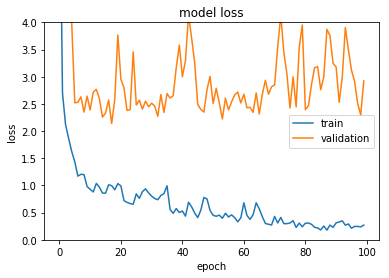

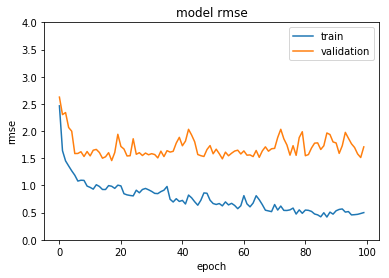

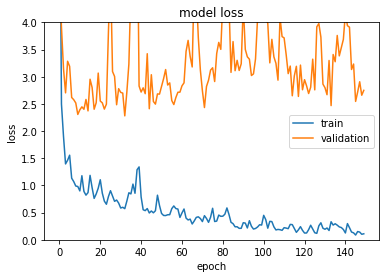

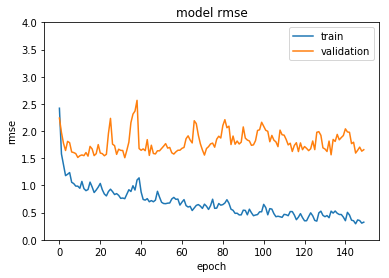

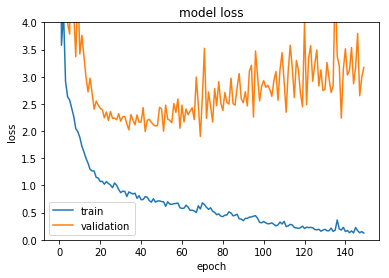

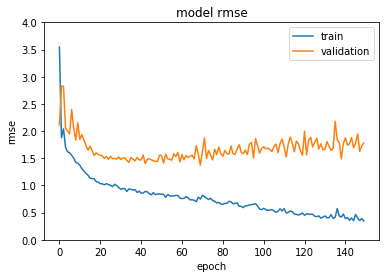

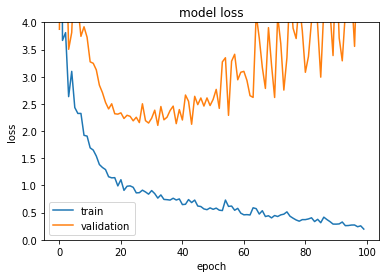

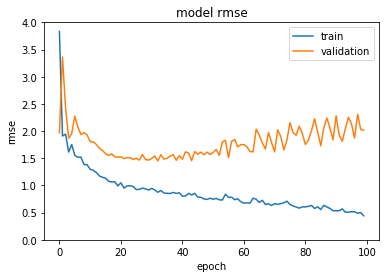

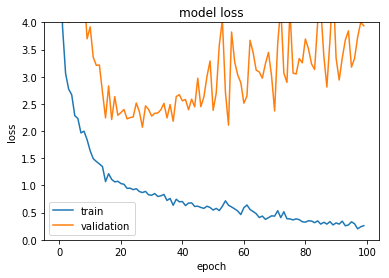

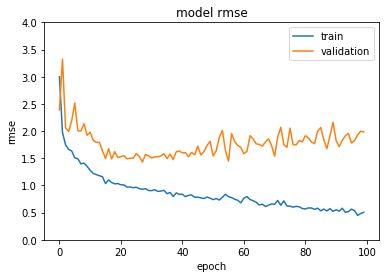

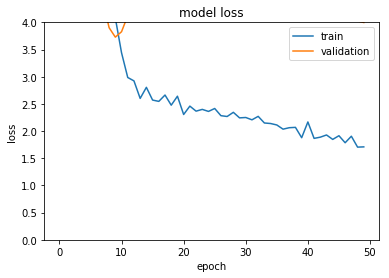

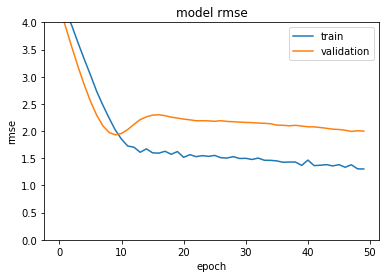

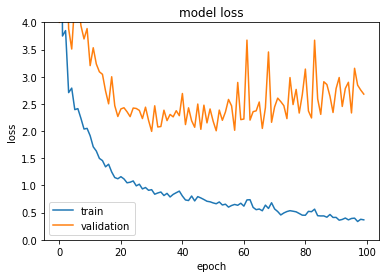

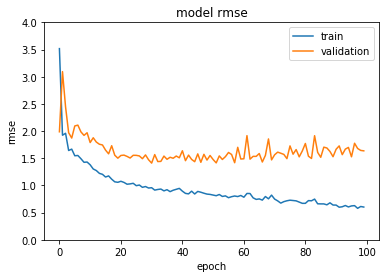

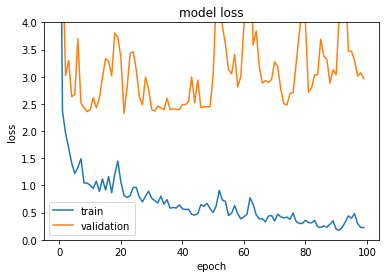

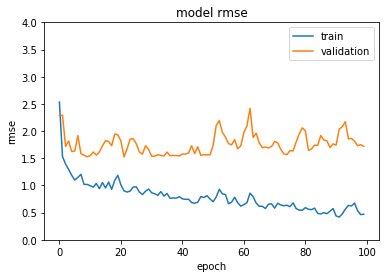

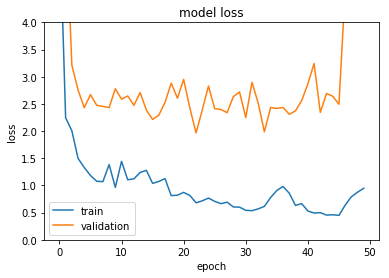

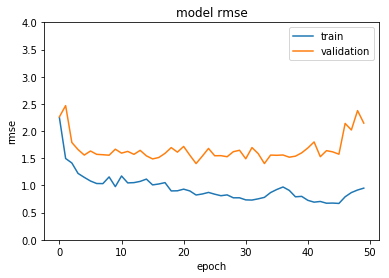

In [0]:
# Ejecutamos la función de entrenamiento con la red InceptionResNetV2
execute10Search('InceptionResNetV2')

### NasNetLarge

343613440/343610240 [==============================] - 3s 0us/step


ITERATION 1 :
 - Name: NasNetLarge
 - Learning Rate: 0.0001
 - Epochs: 100
 - Neurons 1: 1024
 - Neurons 2: 512

Entrenando red...
Instructions for updating:
Use tf.cast instead.

2/1 [=================================================] - 8s 4s/step
test_loss: 1.0417, test_rmse: 1.0202


ITERATION 2 :
 - Name: NasNetLarge
 - Learning Rate: 1e-05
 - Epochs: 50
 - Neurons 1: 736
 - Neurons 2: 276

Entrenando red...

2/1 [=================================================] - 6s 3s/step
test_loss: 1.7918, test_rmse: 1.3385


ITERATION 3 :
 - Name: NasNetLarge
 - Learning Rate: 0.001
 - Epochs: 150
 - Neurons 1: 935
 - Neurons 2: 430

Entrenando red...

2/1 [=================================================] - 6s 3s/step
test_loss: 1.0833, test_rmse: 1.0363


ITERATION 4 :
 - Name: NasNetLarge
 - Learning Rate: 1e-05
 - Epochs: 50
 - Neurons 1: 726
 - Neurons 2: 412

Entrenando red...

2/1 [==================================

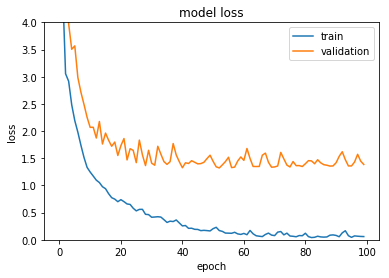

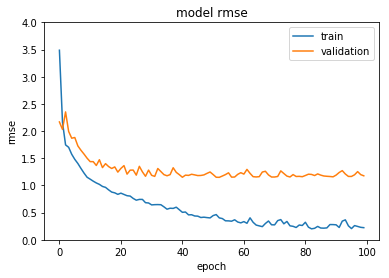

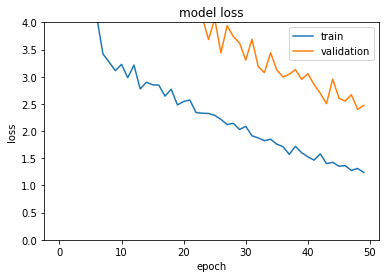

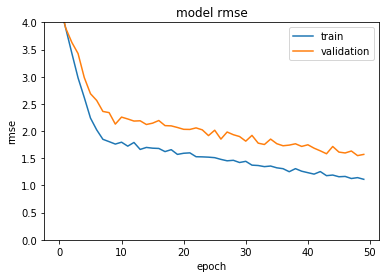

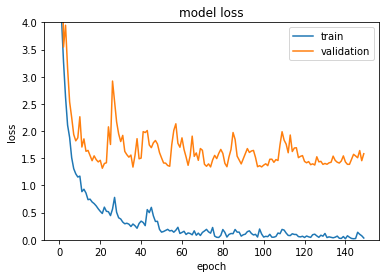

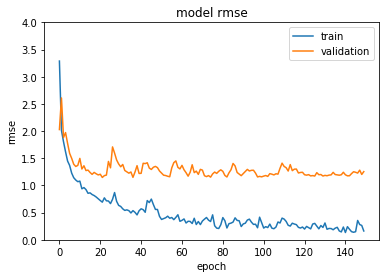

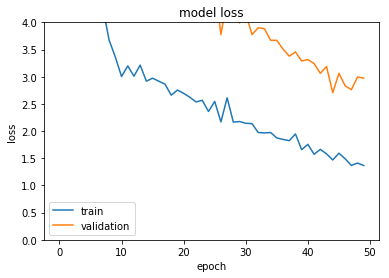

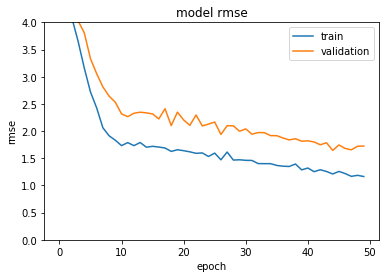

In [0]:
# Ejecutamos la función de entrenamiento con la red NESNetLarge
# IMPORTANTE! El valor de img_width y img_height se tiene que cambiar a 331
execute10Search('NasNetLarge')